In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import subprocess
import numpy as np
import time
import os
import sys

In [24]:
## Variable Define

# Base configuration
BASE_DIR = os.getcwd()
BENCHMARK_DIR = os.path.join(BASE_DIR, "benchmark")
# Add new categories here
LANGUAGES = ['go', 'python', 'c', 'rust']

# Function mappings for each category
FUNCTIONS = ['factorial', 'factors', 'sine', 'cosine', 'sort', 'search', 'reverse', 'sum']
    

In [26]:
DataSet_Generation = False
executable_compilation = True
wasmedge_compilation = False

# Generate file lists dynamically
def generate_file_lists():
    list_of_files = []
    list_of_dockers = []
    list_of_executable = []
    

    for lang in LANGUAGES:
        for func in FUNCTIONS:
            # Source files
            if lang == 'go':
                list_of_files.append(os.path.join(BENCHMARK_DIR, lang, func, "main.go"))
            elif lang == 'python':
                list_of_files.append(os.path.join(BENCHMARK_DIR, lang, func, f"{func}.py"))
            elif lang == 'c':
                list_of_files.append(os.path.join(BENCHMARK_DIR, lang, func, f"{func}.cpp"))
            elif lang == 'rust':
                list_of_files.append(os.path.join(BENCHMARK_DIR, lang, func, "src", "main.rs"))
            
            # Docker files
            if lang == 'python':
                list_of_dockers.append(os.path.join(BENCHMARK_DIR, lang, func, "Dockerfile.alpine"))
            else:
                list_of_dockers.append(os.path.join(BENCHMARK_DIR, lang, func, "Dockerfile"))
                list_of_dockers.append(os.path.join(BENCHMARK_DIR, lang, func, "Dockerfile.alpine"))
            
            # Executable files
            if lang == 'rust':
                list_of_executable.append(os.path.join(BENCHMARK_DIR, lang, func, "target", "x86_64-unknown-linux-gnu", "release", func))
                list_of_executable.append(os.path.join(BENCHMARK_DIR, lang, func, "target", "wasm32-wasip1", "release", f"{func}.wasm"))
            elif lang == 'python':
                list_of_executable.append(os.path.join(BENCHMARK_DIR, lang, func, f"{func}.py"))
                list_of_executable.append(os.path.join(BENCHMARK_DIR, lang, func, f"{func}.wasm"))
            else:
                list_of_executable.append(os.path.join(BENCHMARK_DIR, lang, func, func))
                list_of_executable.append(os.path.join(BENCHMARK_DIR, lang, func, f"{func}.wasm"))

    return list_of_files, list_of_dockers, list_of_executable

# Generate the lists
list_of_files, list_of_dockers, list_of_executable = generate_file_lists()

print(list_of_files)
print(list_of_dockers)
print(list_of_executable)
print(f"Generated {len(list_of_files)} source files")
print(f"Generated {len(list_of_dockers)} docker files") 
print(f"Generated {len(list_of_executable)} executable files")

['/home/yash/Wasm-Benchmark/test/benchmark/go/factorial/main.go', '/home/yash/Wasm-Benchmark/test/benchmark/go/factors/main.go', '/home/yash/Wasm-Benchmark/test/benchmark/go/sine/main.go', '/home/yash/Wasm-Benchmark/test/benchmark/go/cosine/main.go', '/home/yash/Wasm-Benchmark/test/benchmark/go/sort/main.go', '/home/yash/Wasm-Benchmark/test/benchmark/go/search/main.go', '/home/yash/Wasm-Benchmark/test/benchmark/go/reverse/main.go', '/home/yash/Wasm-Benchmark/test/benchmark/go/sum/main.go', '/home/yash/Wasm-Benchmark/test/benchmark/python/factorial/factorial.py', '/home/yash/Wasm-Benchmark/test/benchmark/python/factors/factors.py', '/home/yash/Wasm-Benchmark/test/benchmark/python/sine/sine.py', '/home/yash/Wasm-Benchmark/test/benchmark/python/cosine/cosine.py', '/home/yash/Wasm-Benchmark/test/benchmark/python/sort/sort.py', '/home/yash/Wasm-Benchmark/test/benchmark/python/search/search.py', '/home/yash/Wasm-Benchmark/test/benchmark/python/reverse/reverse.py', '/home/yash/Wasm-Benchmark/

In [10]:

# Display sample of generated lists
print("Sample source files:")
for i, file in enumerate(list_of_files[:5]):
    print(f"  {i+1}. {file}")
print(f"... and {len(list_of_files)-5} more")

print("\nSample docker files:")
for i, file in enumerate(list_of_dockers[:5]):
    print(f"  {i+1}. {file}")
print(f"... and {len(list_of_dockers)-5} more")

print("\nSample executable files:")
for i, file in enumerate(list_of_executable[:5]):
    print(f"  {i+1}. {file}")
print(f"... and {len(list_of_executable)-5} more")

Sample source files:
  1. /home/yash/Wasm-Benchmark/test/benchmark/Math/go/factorial/main.go
  2. /home/yash/Wasm-Benchmark/test/benchmark/Math/go/factors/main.go
  3. /home/yash/Wasm-Benchmark/test/benchmark/Math/go/sine/main.go
  4. /home/yash/Wasm-Benchmark/test/benchmark/Math/go/cosine/main.go
  5. /home/yash/Wasm-Benchmark/test/benchmark/Math/python/factorial/factorial.py
... and 27 more

Sample docker files:
  1. /home/yash/Wasm-Benchmark/test/benchmark/Math/go/factorial/Dockerfile
  2. /home/yash/Wasm-Benchmark/test/benchmark/Math/go/factorial/Dockerfile.alpine
  3. /home/yash/Wasm-Benchmark/test/benchmark/Math/go/factors/Dockerfile
  4. /home/yash/Wasm-Benchmark/test/benchmark/Math/go/factors/Dockerfile.alpine
  5. /home/yash/Wasm-Benchmark/test/benchmark/Math/go/sine/Dockerfile
... and 51 more

Sample executable files:
  1. /home/yash/Wasm-Benchmark/test/benchmark/Math/go/factorial/factorial
  2. /home/yash/Wasm-Benchmark/test/benchmark/Math/go/factorial/factorial.wasm
  3. /h

In [27]:
## compilation
def get_path_info(file_path):
    """Extract category, language, and function from file path"""
    parts = file_path.split(os.sep)
    # Find benchmark directory index
    benchmark_idx = parts.index('benchmark')
    category = parts[benchmark_idx + 1]
    lang = parts[benchmark_idx + 2]
    func = parts[benchmark_idx + 3]
    return category, lang, func

for file in list_of_files:
    if not os.path.exists(file):
        print(f"File not found: {file}")
        continue
        
    category, lang, func = get_path_info(file)
    print(f"Compiling {category}/{lang}/{func}")
    
    ## executable compilation
    if executable_compilation:
        if lang == 'go':
            output_path = os.path.join(BENCHMARK_DIR, category, lang, func, func)
            result = subprocess.run(['go', 'build', '-o', output_path, file], capture_output=True, text=True)
            print(result.stdout)
            print(result.stderr)
        elif lang == 'c':
            output_path = os.path.join(BENCHMARK_DIR, category, lang, func, func)
            result = subprocess.run(['g++', '-o', output_path, file], capture_output=True, text=True)
            print(result.stdout)
            print(result.stderr)
        elif lang == 'rust':
            cargo_path = os.path.join(BENCHMARK_DIR, category, lang, func, 'Cargo.toml')
            result = subprocess.run(['cargo', 'build', '--manifest-path', cargo_path, '--release', '--target=x86_64-unknown-linux-gnu'], capture_output=True, text=True)
            print(result.stdout)    
            print(result.stderr)
            
    ## wasmedge compilation
    if wasmedge_compilation:
        if lang == 'go':
            output_path = os.path.join(BENCHMARK_DIR, category, lang, func, f"{func}.wasm")
            result = subprocess.run(['tinygo', 'build', '-o', output_path, '-target', 'wasi', file], capture_output=True, text=True)
            print(result.stdout)
            print(result.stderr)
        elif lang == 'c':
            output_path = os.path.join(BENCHMARK_DIR, category, lang, func, f"{func}.wasm")
            result = subprocess.run(['/home/yash/wasi-sdk/bin/clang++', '--target=wasm32-wasi', '-o', output_path, file], capture_output=True, text=True)
            print(result.stdout)
            print(result.stderr)
        elif lang == 'rust':
            cargo_path = os.path.join(BENCHMARK_DIR, category, lang, func, 'Cargo.toml')
            result = subprocess.run(['cargo', 'build', '--manifest-path', cargo_path, '--release', '--target=wasm32-wasip1'], capture_output=True, text=True)
            print(result.stdout)
            print(result.stderr)
        elif lang == 'python':
            output_path = os.path.join(BENCHMARK_DIR, category, lang, func, f"{func}.wasm")
            result = subprocess.run(["py2wasm", file], capture_output=True, text=True)
            print(result.stdout)
            print(result.stderr)

Compiling go/factorial/main.go
Compiling go/factors/main.go
Compiling go/sine/main.go
Compiling go/cosine/main.go
Compiling go/sort/main.go
Compiling go/search/main.go
Compiling go/reverse/main.go
Compiling go/sum/main.go
Compiling python/factorial/factorial.py
Compiling python/factors/factors.py
Compiling python/sine/sine.py
Compiling python/cosine/cosine.py
Compiling python/sort/sort.py
Compiling python/search/search.py
Compiling python/reverse/reverse.py
Compiling python/sum/sum.py
Compiling c/factorial/factorial.cpp
Compiling c/factors/factors.cpp
Compiling c/sine/sine.cpp
Compiling c/cosine/cosine.cpp
Compiling c/sort/sort.cpp
Compiling c/search/search.cpp
Compiling c/reverse/reverse.cpp
Compiling c/sum/sum.cpp
Compiling rust/factorial/src
Compiling rust/factors/src
Compiling rust/sine/src
Compiling rust/cosine/src
Compiling rust/sort/src
Compiling rust/search/src
Compiling rust/reverse/src
Compiling rust/sum/src


In [25]:
## docker file building

print(list_of_dockers)

for file in list_of_dockers:
    if not os.path.exists(file):
        print(f"Dockerfile not found: {file}")
        continue
        
    print(f"Building Docker image for {file}")
    category, lang, func = get_path_info(file)
    dockerfile_name = os.path.basename(file)
    build_context = os.path.join(BENCHMARK_DIR, category, lang, func)
    print("build_context", build_context)
    
    print(f"Dockerfile: {dockerfile_name}, Category: {category}, Language: {lang}, Function: {func}")
    
    if dockerfile_name == "Dockerfile.alpine":
        image_tag = f"yaskam24/{lang}_alpine:{category}_{func}"
        result = subprocess.run(["docker", "build", "-t", image_tag, "-f", file, build_context], capture_output=True, text=True)
        print(result.stdout)
    else:
        image_tag = f"yaskam24/{lang}:{category}_{func}"
        result = subprocess.run(["docker", "build", "-t", image_tag, "-f", file, build_context], capture_output=True, text=True)
        print(result.stdout)


['/home/yash/Wasm-Benchmark/test/benchmark/Math/go/factorial/Dockerfile', '/home/yash/Wasm-Benchmark/test/benchmark/Math/go/factorial/Dockerfile.alpine', '/home/yash/Wasm-Benchmark/test/benchmark/Math/go/factors/Dockerfile', '/home/yash/Wasm-Benchmark/test/benchmark/Math/go/factors/Dockerfile.alpine', '/home/yash/Wasm-Benchmark/test/benchmark/Math/go/sine/Dockerfile', '/home/yash/Wasm-Benchmark/test/benchmark/Math/go/sine/Dockerfile.alpine', '/home/yash/Wasm-Benchmark/test/benchmark/Math/go/cosine/Dockerfile', '/home/yash/Wasm-Benchmark/test/benchmark/Math/go/cosine/Dockerfile.alpine', '/home/yash/Wasm-Benchmark/test/benchmark/Math/python/factorial/Dockerfile.alpine', '/home/yash/Wasm-Benchmark/test/benchmark/Math/python/factors/Dockerfile.alpine', '/home/yash/Wasm-Benchmark/test/benchmark/Math/python/sine/Dockerfile.alpine', '/home/yash/Wasm-Benchmark/test/benchmark/Math/python/cosine/Dockerfile.alpine', '/home/yash/Wasm-Benchmark/test/benchmark/Math/c/factorial/Dockerfile', '/home/ya

## DataSet Generation

In [26]:
list_of_results = []
n = len(list_of_dockers)
for file in list_of_dockers:
    if not os.path.exists(file):
        print(f"Dockerfile not found: {file}")
        continue
    print(file)
    category, lang, func = get_path_info(file)
    dockerfile_name = os.path.basename(file)
    print(f"Category: {category}, Function: {func}, Language: {lang}")
    
    if dockerfile_name == "Dockerfile.alpine":
        tag = "alpine"
        image_name = f"yaskam24/{lang}_alpine:{category}_{func}"
        avg_container_creation = 0
        avg_execution_time = 0
        for i in range(1, 11):
            start_time = time.time_ns()
            result = subprocess.run(["docker", "run", "--rm", image_name], capture_output=True, text=True)
            output = result.stdout.split('\n')
            print(output)
            exec_time = None
            for line in output:
                if line.startswith("Execution time:"):
                    exec_time = float(line.split()[2])  # seconds as float
                    break
            Start_time = None
            for line in output:
                if line.startswith("Start time:"):
                    Start_time = line.split()[2]  # seconds as float
                    break
            container_creation_duration = (int(Start_time) - start_time)/1e9
            avg_container_creation += container_creation_duration
            avg_execution_time += exec_time
        avg_container_creation /= 10
        avg_execution_time /= 10
    else:
        tag = "wasmedge/slim-runtime"
        image_name = f"yaskam24/{lang}:{category}_{func}"
        avg_container_creation = 0
        avg_execution_time = 0
        for i in range(1, 11):
            start_time = time.time_ns()
            result = subprocess.run(["docker", "run", "--rm", image_name], capture_output=True, text=True)
            output = result.stdout.split('\n')
            print(output)
            exec_time = None
            for line in output:
                if line.startswith("Execution time:"):
                    exec_time = float(line.split()[2])  # seconds as float
                    break
            Start_time = None
            for line in output:
                if line.startswith("Start time:"):
                    Start_time = line.split()[2]  # seconds as float
                    break
            container_creation_duration = (int(Start_time) - start_time)/1e9
            avg_container_creation += container_creation_duration
            avg_execution_time += exec_time
        avg_execution_time /= 10
        avg_container_creation /= 10
    list_of_results.append({
        "category": category,
        "language": lang,
        "function": func,
        "avg_execution_time": avg_execution_time,
        "start_time": start_time,
        "container_creation": avg_container_creation,
        "Env": tag
    })

container_data = pd.DataFrame(list_of_results)
container_data["Execution_Time"] = container_data["avg_execution_time"] + container_data["container_creation"]
print(container_data.head(n))

container_data.to_csv("benchmarking_results/container_benchmark_results.csv", index=False)

/home/yash/Wasm-Benchmark/test/benchmark/Math/go/factorial/Dockerfile
Category: Math, Function: factorial, Language: go
['Start time: 1757916202887271083 ns', 'Sum of factorials from 1 to 40 is: 836850334330315396667107416678319051186662014976', 'Execution time: 0.000938 seconds', '']
['Start time: 1757916203361091843 ns', 'Sum of factorials from 1 to 40 is: 836850334330315396667107416678319051186662014976', 'Execution time: 0.001012 seconds', '']
['Start time: 1757916203804544813 ns', 'Sum of factorials from 1 to 40 is: 836850334330315396667107416678319051186662014976', 'Execution time: 0.000585 seconds', '']
['Start time: 1757916204199308111 ns', 'Sum of factorials from 1 to 40 is: 836850334330315396667107416678319051186662014976', 'Execution time: 0.000673 seconds', '']
['Start time: 1757916204608650392 ns', 'Sum of factorials from 1 to 40 is: 836850334330315396667107416678319051186662014976', 'Execution time: 0.000606 seconds', '']
['Start time: 1757916205013218397 ns', 'Sum of fac

In [15]:
## executable_data
list_of_results_executable = []
n = len(list_of_executable)

def get_executable_path_info(file_path):
    """Extract category, language, and function from executable file path"""
    parts = file_path.split(os.sep)
    benchmark_idx = parts.index('benchmark')
    category = parts[benchmark_idx + 1]
    lang = parts[benchmark_idx + 2]
    func = parts[benchmark_idx + 3]
    return category, lang, func

for file in list_of_executable:
    if not os.path.exists(file):
        print(f"Executable not found: {file}")
        continue
        
    category, lang, func = get_executable_path_info(file)
    if func == "sort":
        continue
    # Determine if it's wasm or executable
    if file.endswith(".wasm"):
        tag = "wasm"
    else:
        tag = "executable"
    
    print(f"Category: {category}, Function: {func}, Language: {lang}, tag: {tag}")
    
    # Determine input parameter based on category
    if category == "Math":
        input_param = "40"
    elif category == "Array":
        input_param = "10000"  # Array size
    else:
        input_param = "1000"  # Default
    
    avg_execution_time = 0
    for i in range(1, 11):
        if lang == "c" and tag == "executable":
            result = subprocess.run([file, input_param], capture_output=True, text=True)
        elif lang == "go" and tag == "executable":
            result = subprocess.run([file, input_param], capture_output=True, text=True)
        elif lang == "python" and tag == "executable":
            result = subprocess.run(["python", file, input_param], capture_output=True, text=True)
        elif lang == "rust" and tag == "executable":
            result = subprocess.run([file, input_param], capture_output=True, text=True)
        elif tag == "wasm":
            result = subprocess.run(["wasmedge", file, input_param], capture_output=True, text=True)
            # print("wasmedge")
        else:
            continue
    
        result = result.stdout
        output = result.split('\n')
        print(output)
        exec_time = None
        for line in output:
            if line.startswith("Execution time:"):
                exec_time = float(line.split()[2])  # seconds as float
                break
        avg_execution_time += exec_time


    # print(tag)
    list_of_results_executable.append({
        "category": category,
        "language": lang,
        "function": func,
        "execution_time": avg_execution_time/10,
        "Env": tag if tag == "executable" else "wasmedge"  
    })

    # print(category, lang, func, tag)

    avg_execution_time = 0
    if tag == "wasm":
        for i in range(1, 11):
            result = subprocess.run(["wasmtime", file, input_param], capture_output=True, text=True)
            # print("wasmtime")
            result = result.stdout
            output = result.split('\n')
            print(output)
            exec_time = None
            for line in output:
                if line.startswith("Execution time:"):
                    exec_time = float(line.split()[2])  # seconds as float
                    break
            avg_execution_time += exec_time

        list_of_results_executable.append({
            "category": category,
            "language": lang,
            "function": func,
            "execution_time": avg_execution_time/10,
            "Env": "wasmtime"
        })


execution_data = pd.DataFrame(list_of_results_executable)
print(execution_data.head(n))
execution_data.to_csv("benchmarking_results/executable_benchmark_results.csv", index=False)



Category: Math, Function: factorial, Language: go, tag: executable
['Start time: 1758147580044946429 ns', 'Sum of factorials from 1 to 40 is: 836850334330315396667107416678319051186662014976', 'Execution time: 0.000016 seconds', '']
['Start time: 1758147580046848393 ns', 'Sum of factorials from 1 to 40 is: 836850334330315396667107416678319051186662014976', 'Execution time: 0.000024 seconds', '']
['Start time: 1758147580048685800 ns', 'Sum of factorials from 1 to 40 is: 836850334330315396667107416678319051186662014976', 'Execution time: 0.000017 seconds', '']
['Start time: 1758147580050333165 ns', 'Sum of factorials from 1 to 40 is: 836850334330315396667107416678319051186662014976', 'Execution time: 0.000022 seconds', '']
['Start time: 1758147580051839300 ns', 'Sum of factorials from 1 to 40 is: 836850334330315396667107416678319051186662014976', 'Execution time: 0.000012 seconds', '']
['Start time: 1758147580053278927 ns', 'Sum of factorials from 1 to 40 is: 8368503343303153966671074166

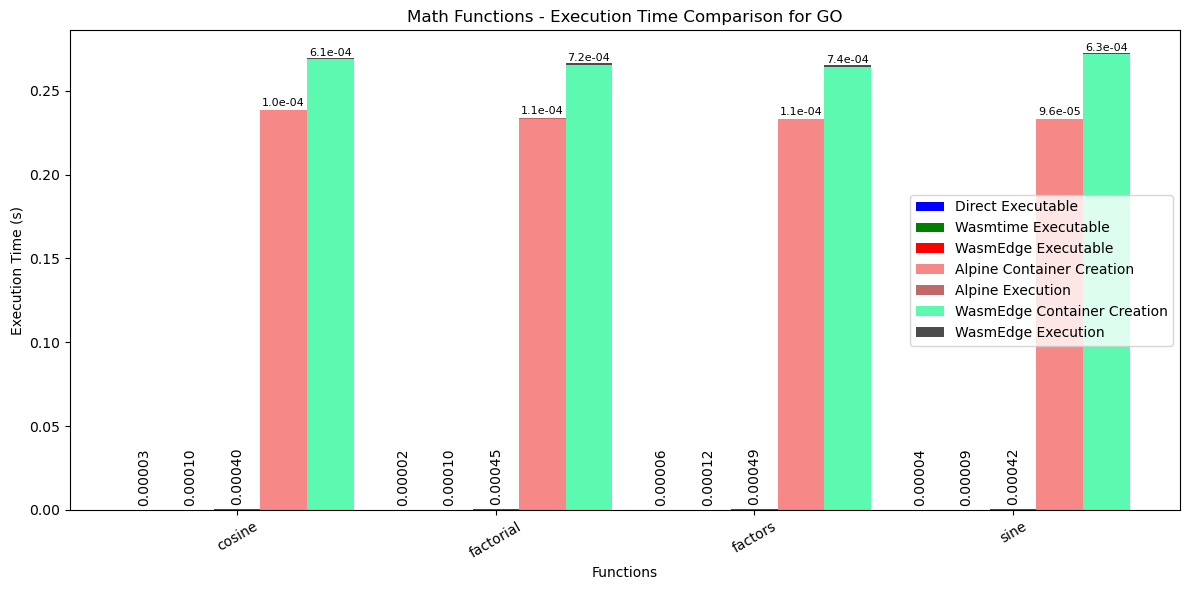

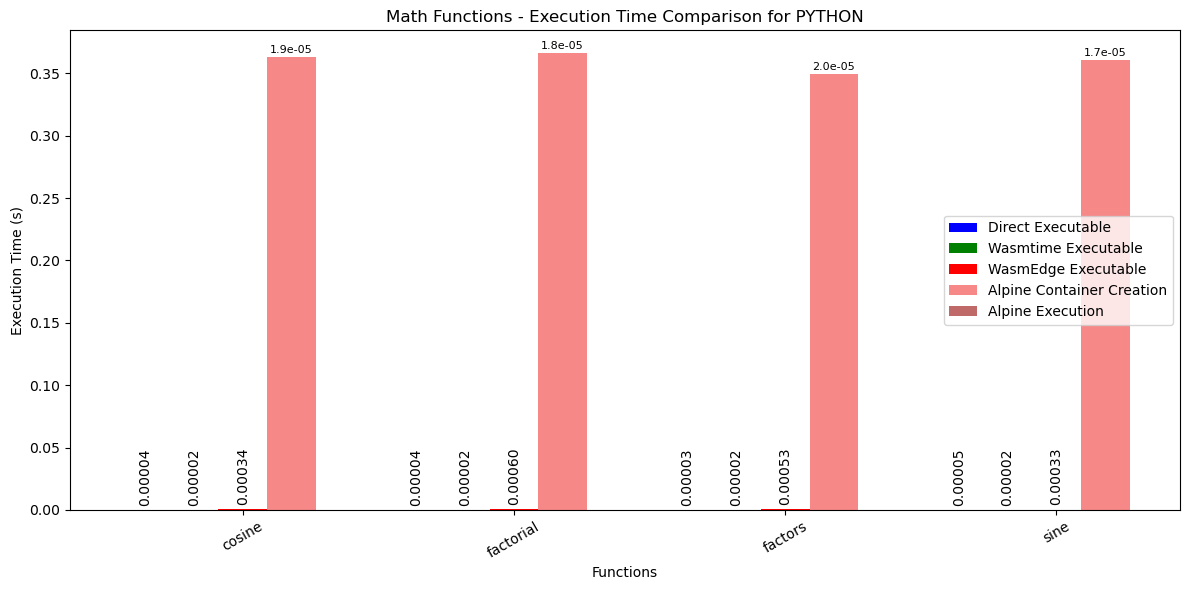

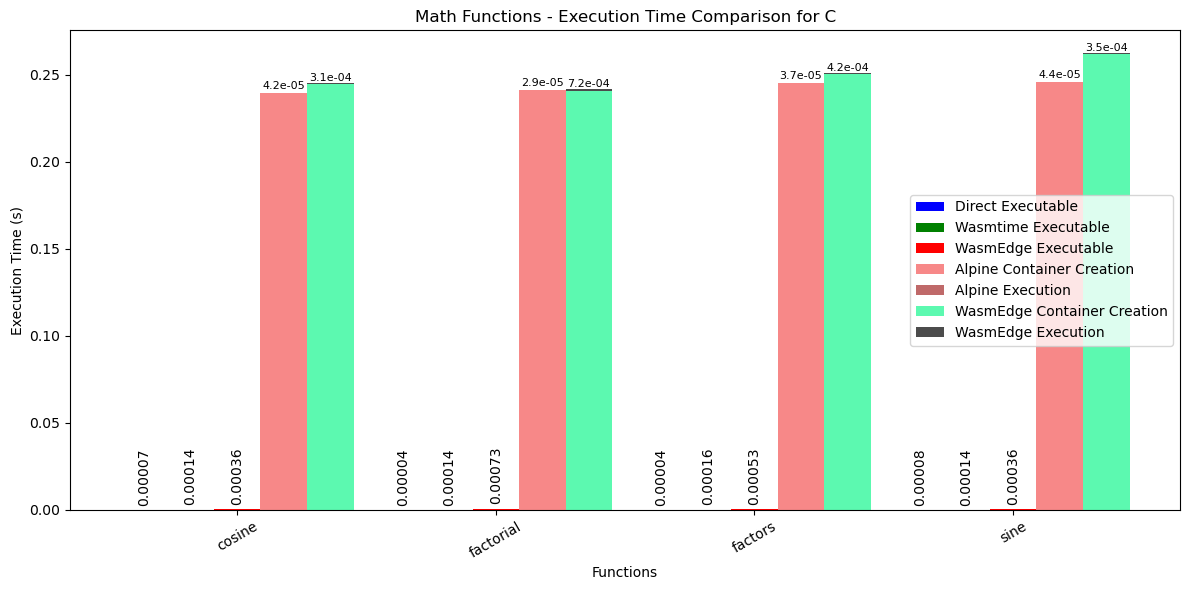

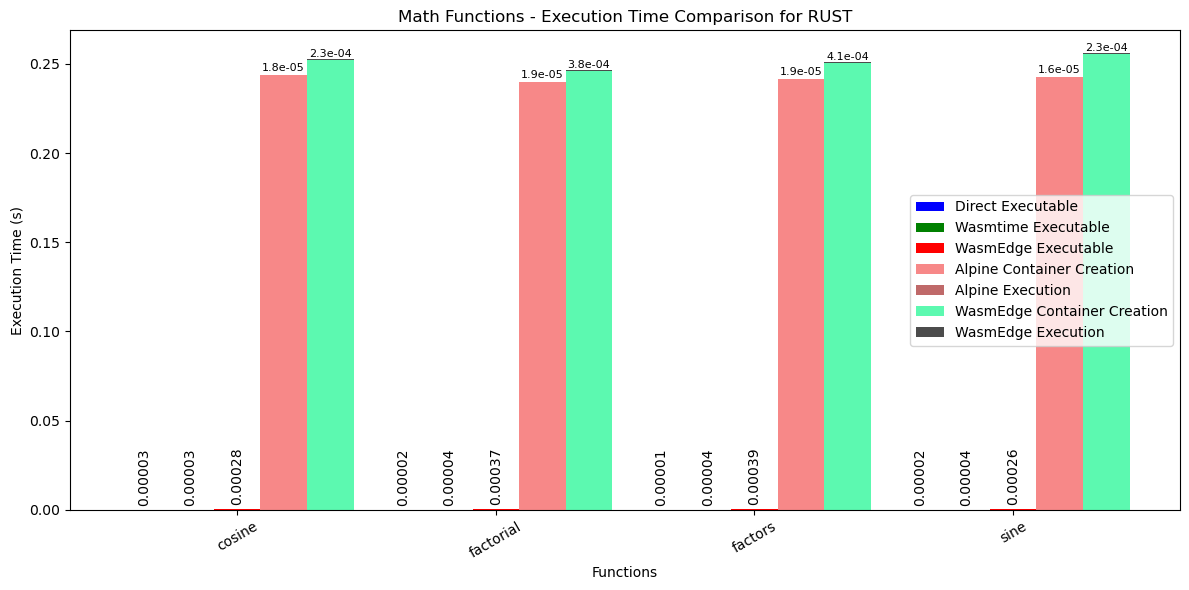

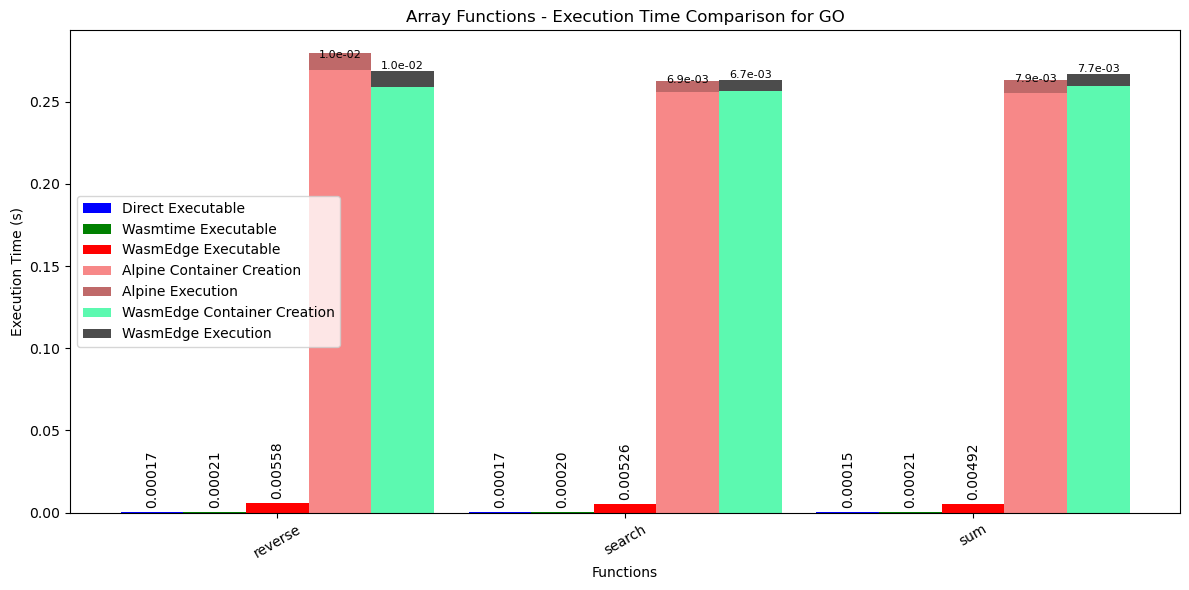

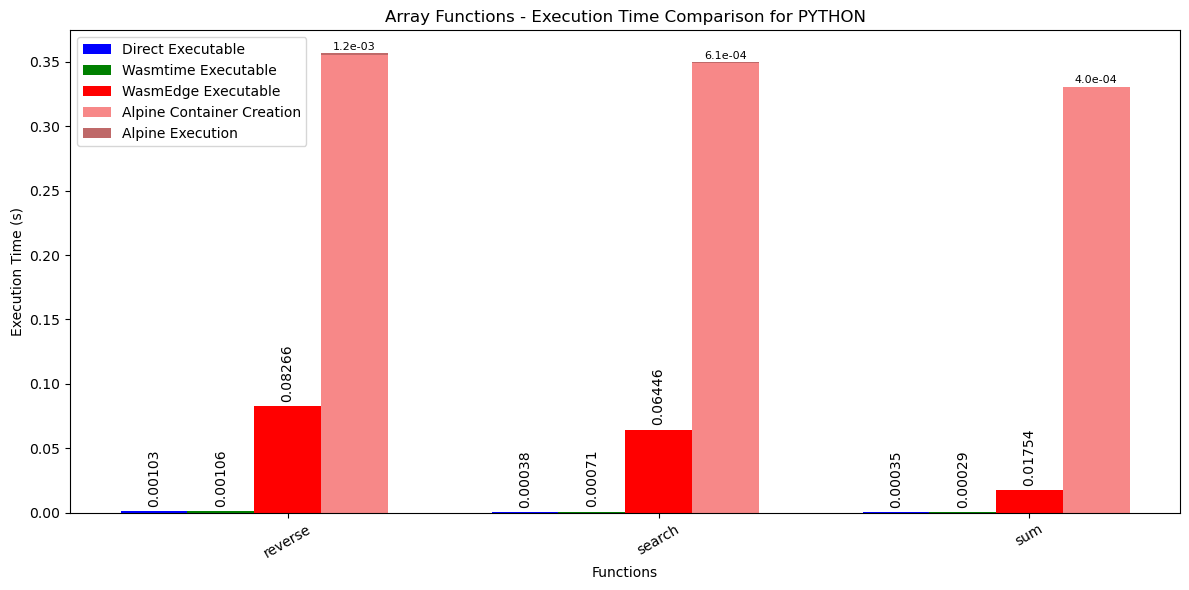

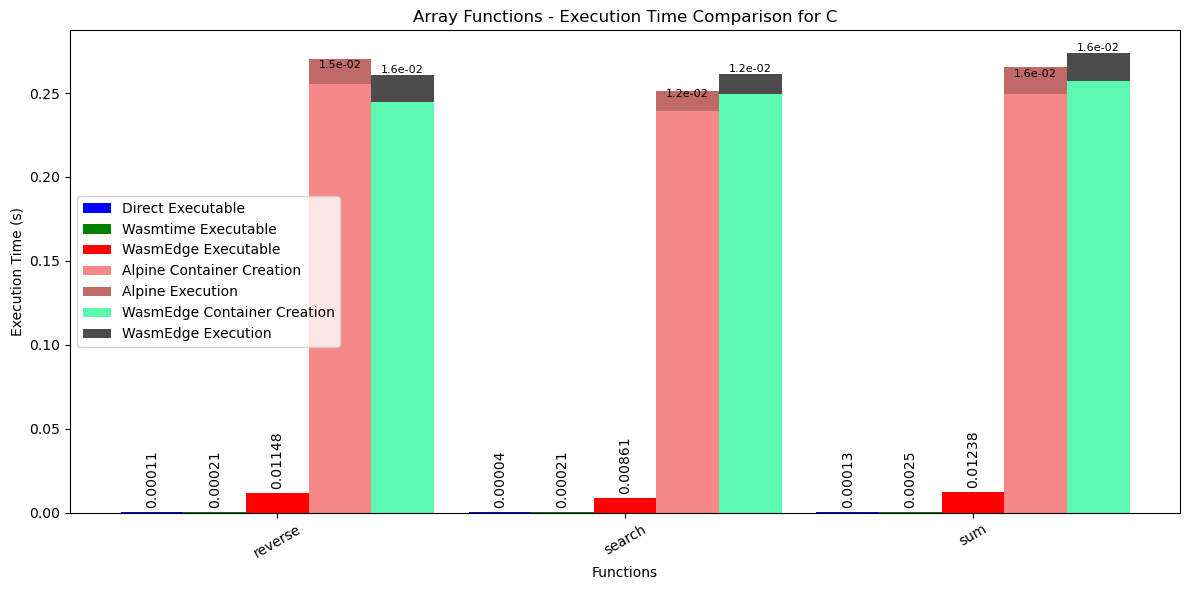

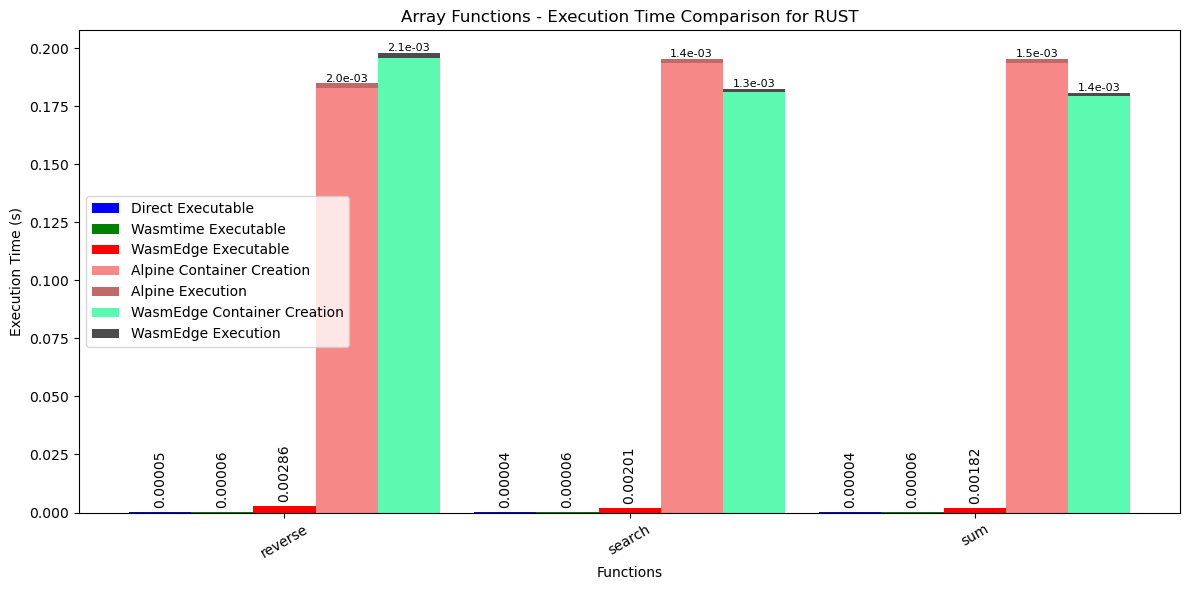

In [ ]:
# direct_executable = execution_data[execution_data['Env'] == 'executable']
# # print(direct_executable)
# print(direct_executable[direct_executable['language'] == 'go'])
# wasmedge_executable = execution_data[execution_data['Env'] == 'wasmedge']
# # print(wasmedge_executable)
# particular_lang = wasmedge_executable[wasmedge_executable['language'] == 'go']
# print(wasmedge_executable[wasmedge_executable['language'] == 'go'])
# print(particular_lang['execution_time'])
# container_data = pd.read_csv("benchmarking_results/container_benchmark_results.csv")
execution_data = pd.read_csv("benchmarking_results/executable_benchmark_results.csv")
container_data = pd.read_csv("benchmarking_results/container_benchmark_results.csv")
# print(container_data)

# Create visualizations for each category and language combination
for category in CATEGORIES:
    for lang in LANGUAGES:
        exec_data = execution_data[execution_data["language"] == lang]
        cont_data = container_data[container_data["language"] == lang]
        
        # Filter by category
        exec_data = exec_data[exec_data["category"] == category]
        cont_data = cont_data[cont_data["category"] == category]
        
        if exec_data.empty and cont_data.empty:
            continue

        
        
        # Split by environment
        direct_exec = exec_data[exec_data["Env"] == "executable"].sort_values(by="function")
        wasmtime_exec = exec_data[exec_data["Env"] == "wasmtime"].sort_values(by="function")

        # print(wasmtime_exec)
        wasmedge_exec = exec_data[exec_data["Env"] == "wasmedge"].sort_values(by="function")

        alpine_cont = cont_data[cont_data["Env"] == "alpine"].sort_values(by="function")
        wasmedge_cont = cont_data[cont_data["Env"] == "wasmedge/slim-runtime"].sort_values(by="function")

        if category == "Array":
            direct_exec = direct_exec[direct_exec["function"] != "sort"]
            wasmedge_exec = wasmedge_exec[wasmedge_exec["function"] != "sort"]
            alpine_cont = alpine_cont[alpine_cont["function"] != "sort"]
            wasmedge_cont = wasmedge_cont[wasmedge_cont["function"] != "sort"]


        # Get unique functions for this category/lang combination
        all_functions = set()
        for df in [direct_exec, wasmedge_exec, alpine_cont, wasmedge_cont]:
            if not df.empty:
                all_functions.update(df["function"].tolist())
        
        functions = sorted(list(all_functions))
        if not functions:
            continue
            
        x = np.arange(len(functions))
        bar_width = 0.18

        plt.figure(figsize=(12, 6))
    
        # Fixed offsets
        offsets = {
            "direct_exec":   -2.0 * bar_width,
            "wasmtime_exec": -1.0 * bar_width,
            "wasmedge_exec":  0.0 * bar_width,
            "alpine_cont":    1.0 * bar_width,
            "wasmedge_cont":  2.0 * bar_width,
        }

        # Plot each environment
        if not direct_exec.empty:
            bar1 = plt.bar(x + offsets["direct_exec"], direct_exec["execution_time"], bar_width,
                        label="Direct Executable", color="blue")

        if not wasmtime_exec.empty:
            bar7 = plt.bar(x + offsets["wasmtime_exec"], wasmtime_exec["execution_time"], bar_width,
                        label="Wasmtime Executable", color="green")

        if not wasmedge_exec.empty:
            bar2 = plt.bar(x + offsets["wasmedge_exec"], wasmedge_exec["execution_time"], bar_width,
                        label="WasmEdge Executable", color="red")

        if not alpine_cont.empty:
            bar3 = plt.bar(x + offsets["alpine_cont"], alpine_cont["container_creation"], bar_width,
                        label="Alpine Container Creation", color="#f56868c9")
            bar5 = plt.bar(x + offsets["alpine_cont"], alpine_cont["avg_execution_time"], bar_width,
                        bottom=alpine_cont["container_creation"], label="Alpine Execution",
                        color="brown", alpha=0.7)

        if not wasmedge_cont.empty:
            bar4 = plt.bar(x + offsets["wasmedge_cont"], wasmedge_cont["container_creation"], bar_width,
                        label="WasmEdge Container Creation", color="#31f89bca")
            bar6 = plt.bar(x + offsets["wasmedge_cont"], wasmedge_cont["avg_execution_time"], bar_width,
                        bottom=wasmedge_cont["container_creation"], label="WasmEdge Execution",
                        color="black", alpha=0.7)

        # Labels and style
        plt.xlabel("Functions")
        plt.ylabel("Execution Time (s)")
        plt.title(f"{category} Functions - Execution Time Comparison for {lang.upper()}")
        plt.xticks(x, functions, rotation=30)
        plt.legend()

        # Add values on bars
        if not direct_exec.empty:
            plt.bar_label(bar1, padding=3, fmt="%.5f", rotation=90)
        if not wasmedge_exec.empty:
            plt.bar_label(bar2, padding=3, fmt="%.5f", rotation=90)
        if not alpine_cont.empty:
            plt.bar_label(bar5, labels=[f"{h:.1e}" for h in alpine_cont["avg_execution_time"]],
                        rotation=0, label_type="center", padding=5, fontsize=8)
        if not wasmedge_cont.empty:
            plt.bar_label(bar6, labels=[f"{h:.1e}" for h in wasmedge_cont["avg_execution_time"]],
                        rotation=0, label_type="edge", fontsize=8)
        if not wasmtime_exec.empty:
            plt.bar_label(bar7, padding=3, fmt="%.5f", rotation=90)

        plt.tight_layout()
        plt.show()